In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers

import seaborn

In [2]:
# 모델 학습 파라미터 설정
batch_size = 32
epochs = 2

max_length = 128  # 모델입력 문장의 최대길이

# Labels in our dataset.
labels = ["contradiction", "entailment", "neutral"]

In [3]:
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.1M  100 11.1M    0     0  28.0M      0 --:--:-- --:--:-- --:--:-- 28.1M
x SNLI_Corpus/
x SNLI_Corpus/snli_1.0_dev.csv
x SNLI_Corpus/snli_1.0_train.csv
x SNLI_Corpus/snli_1.0_test.csv


In [44]:
# 데이터의 일부만 씀 (너무 많아서 조금 제외)
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=100000)
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

# Shape of the data
print("Total train samples:", train_df.shape[0])
print("Total validation samples:", valid_df.shape[0])
print("Total ttest samples:", test_df.shape[0])

Total train samples: 100000
Total validation samples: 10000
Total ttest samples: 10000


# 데이터 형태 분석

In [5]:
train_df

,similarity,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present
...,...,...,...
99995,entailment,People with costumes are gathered in a wooded ...,people wear costumes
99996,contradiction,A girl with a black dress and big white bow st...,a man wearing high heels
99997,entailment,A girl with a black dress and big white bow st...,a girl standing
99998,neutral,A girl with a black dress and big white bow st...,a girl getting ready for photo shoot


In [6]:
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

Number of missing values
similarity    0
sentence1     0
sentence2     3
dtype: int64


In [7]:
print("Train Target Distribution")
print(train_df.similarity.value_counts())

Train Target Distribution
entailment       33384
contradiction    33310
neutral          33193
-                  110
Name: similarity, dtype: int64


<AxesSubplot:>

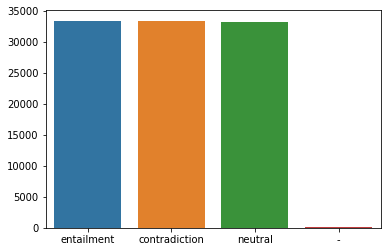

In [8]:
TargetDistribution = train_df.similarity.value_counts()
seaborn.barplot(x=TargetDistribution.index, y=TargetDistribution.values)

In [9]:
print("Validation Target Distribution")
print(valid_df.similarity.value_counts())

Validation Target Distribution
entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: similarity, dtype: int64


In [10]:
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

<AxesSubplot:>

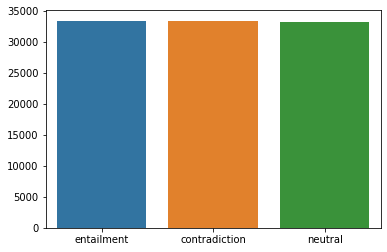

In [11]:
TargetDistribution = train_df.similarity.value_counts()
seaborn.barplot(x=TargetDistribution.index, y=TargetDistribution.values)

In [12]:
# encoding label
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

In [13]:
train_df['label']

0        0
1        0
2        2
3        1
4        0
        ..
99882    1
99883    2
99884    0
99885    0
99886    2
Name: label, Length: 99887, dtype: int64

# 버트 모델의 구현

In [14]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [36]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x00000253AA31C9A0>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
_______________________

# 정의한 Generator를 기반으로 input generator 정의

In [37]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [17]:
pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv").head()

,similarity,sentence1,sentence2
0,neutral,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...
1,entailment,Two women are embracing while holding to go pa...,Two woman are holding packages.
2,contradiction,Two women are embracing while holding to go pa...,The men are fighting outside a deli.
3,entailment,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.
4,neutral,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.


In [18]:
example_item = valid_data.__getitem__(0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
# data example
# [input_ids, attention_masks, token_type_ids]
print(example_item[0][0].shape)
example_item[0][0]

(32, 128)


array([[  101,  1037, 13852, ...,     0,     0,     0],
       [  101,  1996, 10642, ...,     0,     0,     0],
       [  101,  1037,  3203, ...,     0,     0,     0],
       ...,
       [  101,  2093,  3057, ...,     0,     0,     0],
       [  101,  1037,  2402, ...,     0,     0,     0],
       [  101,  1037,  2158, ...,     0,     0,     0]])

In [20]:
# attention mask
print(example_item[0][1].shape)
example_item[0][1]

(32, 128)


array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [21]:
# token_type_ids
print(example_item[0][2].shape)
example_item[0][2]

(32, 128)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
# label example
example_item[1][0]

array([1, 0, 0])

In [23]:
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer) 

In [25]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
    verbose=True
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  51/3121 [..............................] - ETA: 23:36 - loss: 1.0924 - accuracy: 0.4094

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  80/3121 [..............................] - ETA: 23:24 - loss: 1.0792 - accuracy: 0.4182

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 198/3121 [>.............................] - ETA: 22:33 - loss: 1.0017 - accuracy: 0.4840

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 349/3121 [==>...........................] - ETA: 21:27 - loss: 0.9325 - accuracy: 0.5385

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 367/3121 [==>...........................] - ETA: 21:19 - loss: 0.9257 - accuracy: 0.5436

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 411/3121 [==>...........................] - ETA: 20:59 - loss: 0.9101 - accuracy: 0.5550

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 552/3121 [====>.........................] - ETA: 19:55 - loss: 0.8691 - accuracy: 0.5840

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 581/3121 [====>.........................] - ETA: 19:42 - loss: 0.8622 - accuracy: 0.5888

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 590/3121 [====>.........................] - ETA: 19:38 - loss: 0.8601 - accuracy: 0.5902

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 630/3121 [=====>........................] - ETA: 19:19 - loss: 0.8511 - accuracy: 0.5963

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 642/3121 [=====>........................] - ETA: 19:14 - loss: 0.8485 - accuracy: 0.5981

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 686/3121 [=====>........................] - ETA: 18:54 - loss: 0.8394 - accuracy: 0.6042

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 707/3121 [=====>........................] - ETA: 18:44 - loss: 0.8353 - accuracy: 0.6070

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 799/3121 [======>.......................] - ETA: 18:02 - loss: 0.8188 - accuracy: 0.6180

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 838/3121 [=======>......................] - ETA: 17:44 - loss: 0.8123 - accuracy: 0.6223

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 839/3121 [=======>......................] - ETA: 17:43 - loss: 0.8122 - accuracy: 0.6224

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 840/3121 [=======>......................] - ETA: 17:43 - loss: 0.8120 - accuracy: 0.6225

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 936/3121 [=======>......................] - ETA: 16:58 - loss: 0.7974 - accuracy: 0.6320

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 967/3121 [========>.....................] - ETA: 16:44 - loss: 0.7931 - accuracy: 0.6348

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1075/3121 [=========>....................] - ETA: 15:54 - loss: 0.7793 - accuracy: 0.6437

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1089/3121 [=========>....................] - ETA: 15:47 - loss: 0.7777 - accuracy: 0.6448

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1098/3121 [=========>....................] - ETA: 15:43 - loss: 0.7766 - accuracy: 0.6455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1105/3121 [=========>....................] - ETA: 15:40 - loss: 0.7758 - accuracy: 0.6460

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1223/3121 [==========>...................] - ETA: 14:45 - loss: 0.7628 - accuracy: 0.6542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1328/3121 [===========>..................] - ETA: 13:56 - loss: 0.7524 - accuracy: 0.6608

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1334/3121 [===========>..................] - ETA: 13:53 - loss: 0.7518 - accuracy: 0.6611

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1358/3121 [============>.................] - ETA: 13:42 - loss: 0.7496 - accuracy: 0.6625

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1374/3121 [============>.................] - ETA: 13:35 - loss: 0.7481 - accuracy: 0.6634

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1423/3121 [============>.................] - ETA: 13:12 - loss: 0.7437 - accuracy: 0.6661

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1424/3121 [============>.................] - ETA: 13:12 - loss: 0.7436 - accuracy: 0.6662

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1573/3121 [==============>...............] - ETA: 12:02 - loss: 0.7313 - accuracy: 0.6737

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1600/3121 [==============>...............] - ETA: 11:50 - loss: 0.7292 - accuracy: 0.6750

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1625/3121 [==============>...............] - ETA: 11:38 - loss: 0.7272 - accuracy: 0.6762

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1653/3121 [==============>...............] - ETA: 11:25 - loss: 0.7251 - accuracy: 0.6775

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1674/3121 [===============>..............] - ETA: 11:15 - loss: 0.7235 - accuracy: 0.6784

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1687/3121 [===============>..............] - ETA: 11:09 - loss: 0.7226 - accuracy: 0.6790

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1821/3121 [================>.............] - ETA: 10:07 - loss: 0.7131 - accuracy: 0.6846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1884/3121 [=================>............] - ETA: 9:37 - loss: 0.7090 - accuracy: 0.6871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1924/3121 [=================>............] - ETA: 9:18 - loss: 0.7064 - accuracy: 0.6885

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1938/3121 [=================>............] - ETA: 9:12 - loss: 0.7056 - accuracy: 0.6891

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2011/3121 [==================>...........] - ETA: 8:38 - loss: 0.7011 - accuracy: 0.6917

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2038/3121 [==================>...........] - ETA: 8:25 - loss: 0.6995 - accuracy: 0.6926

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2088/3121 [===================>..........] - ETA: 8:02 - loss: 0.6966 - accuracy: 0.6943

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2102/3121 [===================>..........] - ETA: 7:55 - loss: 0.6958 - accuracy: 0.6948

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2108/3121 [===================>..........] - ETA: 7:53 - loss: 0.6954 - accuracy: 0.6950

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2139/3121 [===================>..........] - ETA: 7:38 - loss: 0.6937 - accuracy: 0.6960

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2274/3121 [====================>.........] - ETA: 6:35 - loss: 0.6864 - accuracy: 0.7002

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2296/3121 [=====================>........] - ETA: 6:25 - loss: 0.6853 - accuracy: 0.7008

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2309/3121 [=====================>........] - ETA: 6:19 - loss: 0.6846 - accuracy: 0.7012

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2353/3121 [=====================>........] - ETA: 5:58 - loss: 0.6824 - accuracy: 0.7025

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2369/3121 [=====================>........] - ETA: 5:51 - loss: 0.6816 - accuracy: 0.7030

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2492/3121 [======================>.......] - ETA: 4:53 - loss: 0.6756 - accuracy: 0.7064

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2561/3121 [=======================>......] - ETA: 4:21 - loss: 0.6724 - accuracy: 0.7083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2564/3121 [=======================>......] - ETA: 4:20 - loss: 0.6723 - accuracy: 0.7083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2572/3121 [=======================>......] - ETA: 4:16 - loss: 0.6719 - accuracy: 0.7085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2602/3121 [========================>.....] - ETA: 4:02 - loss: 0.6705 - accuracy: 0.7093

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2626/3121 [========================>.....] - ETA: 3:51 - loss: 0.6695 - accuracy: 0.7099

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2676/3121 [========================>.....] - ETA: 3:27 - loss: 0.6673 - accuracy: 0.7112

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2687/3121 [========================>.....] - ETA: 3:22 - loss: 0.6668 - accuracy: 0.7115

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2695/3121 [========================>.....] - ETA: 3:19 - loss: 0.6664 - accuracy: 0.7117

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2708/3121 [=========================>....] - ETA: 3:12 - loss: 0.6659 - accuracy: 0.7120

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2718/3121 [=========================>....] - ETA: 3:08 - loss: 0.6654 - accuracy: 0.7122

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2730/3121 [=========================>....] - ETA: 3:02 - loss: 0.6649 - accuracy: 0.7125

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2833/3121 [==========================>...] - ETA: 2:14 - loss: 0.6606 - accuracy: 0.7149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2846/3121 [==========================>...] - ETA: 2:08 - loss: 0.6601 - accuracy: 0.7152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2882/3121 [==========================>...] - ETA: 1:51 - loss: 0.6587 - accuracy: 0.7160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2887/3121 [==========================>...] - ETA: 1:49 - loss: 0.6585 - accuracy: 0.7162

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2899/3121 [==========================>...] - ETA: 1:43 - loss: 0.6580 - accuracy: 0.7164

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2904/3121 [==========================>...] - ETA: 1:41 - loss: 0.6578 - accuracy: 0.7165

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2930/3121 [===========================>..] - ETA: 1:29 - loss: 0.6568 - accuracy: 0.7171

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2979/3121 [===========================>..] - ETA: 1:06 - loss: 0.6549 - accuracy: 0.7182

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2981/3121 [===========================>..] - ETA: 1:05 - loss: 0.6548 - accuracy: 0.7182

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2993/3121 [===========================>..] - ETA: 59s - loss: 0.6543 - accuracy: 0.7185 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3014/3121 [===========================>..] - ETA: 49s - loss: 0.6536 - accuracy: 0.7189

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3017/3121 [============================>.] - ETA: 48s - loss: 0.6534 - accuracy: 0.7190

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3046/3121 [============================>.] - ETA: 35s - loss: 0.6524 - accuracy: 0.7196

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3047/3121 [============================>.] - ETA: 34s - loss: 0.6523 - accuracy: 0.7196

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.7211

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - 1525s 484ms/step - loss: 0.6496 - accuracy: 0.7212 - val_loss: 0.3778 - val_accuracy: 0.8582
Epoch 2/2
   9/3121 [..............................] - ETA: 24:15 - loss: 0.3199 - accuracy: 0.8733

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  45/3121 [..............................] - ETA: 23:58 - loss: 0.3699 - accuracy: 0.8565

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 173/3121 [>.............................] - ETA: 22:59 - loss: 0.3738 - accuracy: 0.8586

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 193/3121 [>.............................] - ETA: 22:49 - loss: 0.3741 - accuracy: 0.8585

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 235/3121 [=>............................] - ETA: 22:30 - loss: 0.3744 - accuracy: 0.8587

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 261/3121 [=>............................] - ETA: 22:18 - loss: 0.3744 - accuracy: 0.8589

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 301/3121 [=>............................] - ETA: 21:59 - loss: 0.3741 - accuracy: 0.8593

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 408/3121 [==>...........................] - ETA: 21:09 - loss: 0.3736 - accuracy: 0.8600

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 451/3121 [===>..........................] - ETA: 20:49 - loss: 0.3734 - accuracy: 0.8602

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 472/3121 [===>..........................] - ETA: 20:39 - loss: 0.3733 - accuracy: 0.8603

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 567/3121 [====>.........................] - ETA: 19:54 - loss: 0.3728 - accuracy: 0.8606

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 752/3121 [======>.......................] - ETA: 18:28 - loss: 0.3713 - accuracy: 0.8613

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 818/3121 [======>.......................] - ETA: 17:57 - loss: 0.3711 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 872/3121 [=======>......................] - ETA: 17:32 - loss: 0.3711 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 876/3121 [=======>......................] - ETA: 17:30 - loss: 0.3711 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 877/3121 [=======>......................] - ETA: 17:30 - loss: 0.3712 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 941/3121 [========>.....................] - ETA: 17:00 - loss: 0.3713 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 981/3121 [========>.....................] - ETA: 16:41 - loss: 0.3713 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 995/3121 [========>.....................] - ETA: 16:34 - loss: 0.3713 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1083/3121 [=========>....................] - ETA: 15:53 - loss: 0.3713 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1111/3121 [=========>....................] - ETA: 15:40 - loss: 0.3713 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1126/3121 [=========>....................] - ETA: 15:33 - loss: 0.3713 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1130/3121 [=========>....................] - ETA: 15:31 - loss: 0.3713 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1164/3121 [==========>...................] - ETA: 15:15 - loss: 0.3713 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1201/3121 [==========>...................] - ETA: 14:58 - loss: 0.3713 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1240/3121 [==========>...................] - ETA: 14:40 - loss: 0.3713 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1280/3121 [===========>..................] - ETA: 14:21 - loss: 0.3713 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1296/3121 [===========>..................] - ETA: 14:14 - loss: 0.3713 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1370/3121 [============>.................] - ETA: 13:39 - loss: 0.3712 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1381/3121 [============>.................] - ETA: 13:34 - loss: 0.3712 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1385/3121 [============>.................] - ETA: 13:32 - loss: 0.3712 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1423/3121 [============>.................] - ETA: 13:14 - loss: 0.3712 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1438/3121 [============>.................] - ETA: 13:07 - loss: 0.3712 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1442/3121 [============>.................] - ETA: 13:05 - loss: 0.3712 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1482/3121 [=============>................] - ETA: 12:47 - loss: 0.3712 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1485/3121 [=============>................] - ETA: 12:45 - loss: 0.3712 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1501/3121 [=============>................] - ETA: 12:38 - loss: 0.3712 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1537/3121 [=============>................] - ETA: 12:21 - loss: 0.3712 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1571/3121 [==============>...............] - ETA: 12:05 - loss: 0.3712 - accuracy: 0.8615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1846/3121 [================>.............] - ETA: 9:56 - loss: 0.3710 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1917/3121 [=================>............] - ETA: 9:23 - loss: 0.3710 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1939/3121 [=================>............] - ETA: 9:13 - loss: 0.3710 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1964/3121 [=================>............] - ETA: 9:01 - loss: 0.3709 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2026/3121 [==================>...........] - ETA: 8:32 - loss: 0.3709 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2047/3121 [==================>...........] - ETA: 8:22 - loss: 0.3709 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2102/3121 [===================>..........] - ETA: 7:57 - loss: 0.3708 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2131/3121 [===================>..........] - ETA: 7:43 - loss: 0.3708 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2233/3121 [====================>.........] - ETA: 6:55 - loss: 0.3707 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2239/3121 [====================>.........] - ETA: 6:52 - loss: 0.3707 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2286/3121 [====================>.........] - ETA: 6:30 - loss: 0.3707 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2341/3121 [=====================>........] - ETA: 6:05 - loss: 0.3707 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2373/3121 [=====================>........] - ETA: 5:50 - loss: 0.3707 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2378/3121 [=====================>........] - ETA: 5:47 - loss: 0.3707 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2399/3121 [======================>.......] - ETA: 5:38 - loss: 0.3707 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2406/3121 [======================>.......] - ETA: 5:34 - loss: 0.3707 - accuracy: 0.8616

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2465/3121 [======================>.......] - ETA: 5:07 - loss: 0.3706 - accuracy: 0.8617

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2474/3121 [======================>.......] - ETA: 5:02 - loss: 0.3706 - accuracy: 0.8617

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2509/3121 [=======================>......] - ETA: 4:46 - loss: 0.3706 - accuracy: 0.8617

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2584/3121 [=======================>......] - ETA: 4:11 - loss: 0.3705 - accuracy: 0.8617

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2657/3121 [========================>.....] - ETA: 3:37 - loss: 0.3704 - accuracy: 0.8617

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2676/3121 [========================>.....] - ETA: 3:28 - loss: 0.3704 - accuracy: 0.8617

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2683/3121 [========================>.....] - ETA: 3:25 - loss: 0.3704 - accuracy: 0.8617

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2693/3121 [========================>.....] - ETA: 3:20 - loss: 0.3704 - accuracy: 0.8617

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2706/3121 [=========================>....] - ETA: 3:14 - loss: 0.3704 - accuracy: 0.8617

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2723/3121 [=========================>....] - ETA: 3:06 - loss: 0.3704 - accuracy: 0.8618

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2765/3121 [=========================>....] - ETA: 2:46 - loss: 0.3704 - accuracy: 0.8618

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2770/3121 [=========================>....] - ETA: 2:44 - loss: 0.3703 - accuracy: 0.8618

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2859/3121 [==========================>...] - ETA: 2:03 - loss: 0.3702 - accuracy: 0.8618

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2878/3121 [==========================>...] - ETA: 1:54 - loss: 0.3702 - accuracy: 0.8618

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2883/3121 [==========================>...] - ETA: 1:52 - loss: 0.3702 - accuracy: 0.8618

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2915/3121 [===========================>..] - ETA: 1:37 - loss: 0.3702 - accuracy: 0.8618

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2961/3121 [===========================>..] - ETA: 1:15 - loss: 0.3702 - accuracy: 0.8618

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3026/3121 [============================>.] - ETA: 44s - loss: 0.3701 - accuracy: 0.8619

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3032/3121 [============================>.] - ETA: 41s - loss: 0.3701 - accuracy: 0.8619

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3074/3121 [============================>.] - ETA: 22s - loss: 0.3701 - accuracy: 0.8619

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3085/3121 [============================>.] - ETA: 16s - loss: 0.3700 - accuracy: 0.8619

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3086/3121 [============================>.] - ETA: 16s - loss: 0.3700 - accuracy: 0.8619

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - ETA: 0s - loss: 0.3700 - accuracy: 0.8619

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - 1520s 487ms/step - loss: 0.3700 - accuracy: 0.8619 - val_loss: 0.3466 - val_accuracy: 0.8724


In [26]:
test_data = BertSemanticDataGenerator(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_data, verbose=1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


 69/312 [=====>........................] - ETA: 39s - loss: 0.3808 - accuracy: 0.8542

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 82/312 [======>.......................] - ETA: 37s - loss: 0.3754 - accuracy: 0.8567

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


312/312 [==============================] - 51s 162ms/step - loss: 0.3628 - accuracy: 0.8646


[0.3627733886241913, 0.8645833134651184]

In [27]:
def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data[0])[0]
    idx = np.argmax(proba)
    proba = f"{proba[idx]: .2f}%"
    pred = labels[idx]
    return pred, proba

In [41]:
sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
sentence_pairs    

array([['I study data science', 'I am taking a data science class']],
      dtype='<U32')

In [42]:
test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
)

In [43]:
proba = model.predict(test_data[0])[0]
proba

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


array([0.05183051, 0.07054332, 0.8776262 ], dtype=float32)

In [ ]:
idx = np.argmax(proba)
proba = f"{proba[idx]: .2f}%"
pred = labels[idx]
return pred, proba

In [28]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


('contradiction', ' 0.90%')

In [29]:
sentence1 = "A smiling costumed woman is holding an umbrella"
sentence2 = "A happy woman in a fairy costume holds an umbrella"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


('neutral', ' 0.89%')

In [30]:
sentence1 = "A soccer game with multiple males playing"
sentence2 = "Some men are playing a sport"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


('entailment', ' 0.95%')

In [31]:
sentence1 = "I study data science"
sentence2 = "I conduct taking a data science class"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


('neutral', ' 0.88%')